## Sentiment Classifier (Positive News / Other News)

Instead of Positive, Negative, and Neutral News, we will only classify news as 'positive' (1) or otherwise (0), since we are only concerned with positive articles and our dataset is comprised of positive and unclassified news (removed suspected positive articles through pre-defined sentiment analysis tool `textblob`).

Reference: https://chrisalbon.com/machine_learning/preprocessing_text/tf-idf/

In [144]:
import pandas as pd
import matplotlib.pyplot as plt
from textblob import TextBlob
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

___

### Cleaning 'Other' (Negative/Neutral) Articles

In [31]:
df_other = pd.read_json('data/unclassifiedarticles.json')

In [32]:
def calculate_polarity(row):
    return TextBlob(row).sentiment.polarity
    
df_other['polarity'] = df_other['transcript'].apply(calculate_polarity)

In [33]:
df_other['polarity'].describe()

count    1013.000000
mean        0.076154
std         0.073877
min        -0.347619
25%         0.037120
50%         0.076446
75%         0.117075
max         0.408225
Name: polarity, dtype: float64

#### Removing suspected positive articles

In [34]:
df_other = df_other[df_other['polarity'] <= 0.117] # Remove everything above 75% percentile

In [35]:
len(df_other)

759

#### Assumption: All articles in the current 'df_other' are either negative or neutral, and none are clearly positive.

---

### Cleaning Positive Articles

In [36]:
df_positive = pd.read_json('data/total_data_2.json')

In [42]:
df_positive = df_positive.drop('Unnamed: 0', axis = 1)

In [37]:
def calculate_polarity(row):
    return TextBlob(row).sentiment.polarity
    
df_positive['polarity'] = df_positive['transcript'].apply(calculate_polarity)

In [38]:
df_positive['polarity'].describe()

count    1062.000000
mean        0.135837
std         0.178191
min        -0.133333
25%         0.041512
50%         0.108415
75%         0.171805
max         1.000000
Name: polarity, dtype: float64

In [28]:
df_positive = df_positive[df_positive['polarity'] >= 0.04] # Remove everything below 25% percentile

In [30]:
len(df_positive)

798

____

### Data Joining, Pre-Processing and Feature Engineering

In [50]:
df_positive['positivity'] = 1
df_other['positivity'] = 0

In [99]:
df = pd.concat([df_positive, df_other])

In [100]:
df.head(2)

,title,url,date,transcript,source,polarity,positivity
0,16-Year-Old Has Been Using His Flying Lessons ...,https://www.goodnewsnetwork.org/teen-flies-sup...,2020-04-09,16-year-old TJ Kim may not have his driver’s l...,goodnewsnetwork.org,0.214592,1
1,Tyler Perry Picks Up the Tab for All Groceries...,https://www.goodnewsnetwork.org/tyler-perry-pa...,2020-04-09,It’s not uncommon for movie mogul Tyler Perry ...,goodnewsnetwork.org,0.234015,1


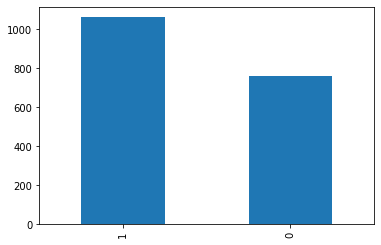

In [101]:
df['positivity'].value_counts().plot(kind="bar")

In [102]:
df = df.drop('polarity', axis = 1)

In [103]:
df.head(2)

,title,url,date,transcript,source,positivity
0,16-Year-Old Has Been Using His Flying Lessons ...,https://www.goodnewsnetwork.org/teen-flies-sup...,2020-04-09,16-year-old TJ Kim may not have his driver’s l...,goodnewsnetwork.org,1
1,Tyler Perry Picks Up the Tab for All Groceries...,https://www.goodnewsnetwork.org/tyler-perry-pa...,2020-04-09,It’s not uncommon for movie mogul Tyler Perry ...,goodnewsnetwork.org,1


___

### Classifier

In [104]:
v = TfidfVectorizer(stop_words=stopwords.words('english'))

In [120]:
X = df['transcript']
y = df['positivity']

In [121]:
X_tfidf = v.fit_transform(X).toarray()

In [124]:
x_train, x_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2)

In [140]:
model_svm = LinearSVC().fit(x_train, y_train)

In [141]:
predictions = model_svm.predict(x_test)

In [142]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.94      0.94      0.94       140
           1       0.96      0.96      0.96       225

    accuracy                           0.95       365
   macro avg       0.95      0.95      0.95       365
weighted avg       0.95      0.95      0.95       365



___